# Test Training Real waste
## Source :https://archive.ics.uci.edu/dataset/908/realwaste


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import MaxPool2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
# compile model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf
from tensorflow.keras import Sequential



def load_image():
	'''
	Load images from directory

	:param dir: directory of images
	:return: image generator
	'''

	'''
							rotation_range=40,
							shear_range=0.2,
							zoom_range=0.2,
							horizontal_flip=True,
							fill_mode='nearest','''
	
	dir = 'RealWaste'
	datagen = ImageDataGenerator(rescale=1./255,
							    horizontal_flip=True,
								vertical_flip=True,
								channel_shift_range=100,
								rotation_range=90,
								validation_split=0.2,
							)  # Normalize images
	
	train_gen = datagen.flow_from_directory(
		dir,
		target_size=(224, 224),
		batch_size=64,
		class_mode='categorical',
		subset='training',
	)

	val_gen = datagen.flow_from_directory(
		dir,
		target_size=(224, 224),
		batch_size=64,
		class_mode='categorical',
		subset='validation',
	)

	return train_gen, val_gen


def load_model():
    
	base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                   weights='imagenet',
                                                   input_shape=(224, 224, 3))
	base_model.trainable = False  # Freeze the base model


    # Set the entire model's layers to non-trainable
	base_model.trainable = False

	return base_model


def build_model(base_model, output_dim=2):
	'''
	Build a model on top of the base model
	
	:param base_model: base model
	:param output_dim: number of output classes
	:return: model
	'''
	model = base_model.output
	model = MaxPool2D(pool_size=(7, 7))(model)
	model = Flatten()(model)
	model = Dense(128, activation='relu')(model)
	model = Dropout(0.5)(model)
	model = Dense(output_dim, activation='softmax')(model)

	return model



	

In [18]:
train_gen, val_gen = load_image()

num_classes = train_gen.num_classes


Found 3803 images belonging to 9 classes.
Found 949 images belonging to 9 classes.


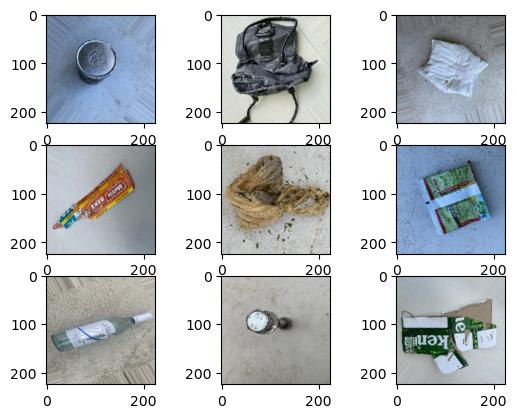

In [19]:
# show one image
import matplotlib.pyplot as plt

for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = train_gen.next()
	image = batch[0][0]
	plt.imshow(image)

In [20]:
# load model
base_model = load_model()
#Yhat = build_model(base_model, train_gen.num_classes)


model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))




In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 9)                 11529     
                                                                 
Total params: 4061100 (15.49 MB)
Trainable params: 11529 (45.04 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [23]:

model.compile(
	optimizer=Adam(learning_rate=1e-2),
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

# train model
model.fit(
	train_gen,
	epochs=20,
	steps_per_epoch=train_gen.samples // train_gen.batch_size,
	validation_data=val_gen,

)

Epoch 1/20
118/118 [==============================] - 52s 413ms/step - loss: 2.3660 - accuracy: 0.1501 - val_loss: 2.2955 - val_accuracy: 0.1939
Epoch 2/20
118/118 [==============================] - 49s 410ms/step - loss: 2.3515 - accuracy: 0.1493 - val_loss: 2.2635 - val_accuracy: 0.1054
Epoch 3/20
118/118 [==============================] - 51s 420ms/step - loss: 2.3634 - accuracy: 0.1549 - val_loss: 2.2172 - val_accuracy: 0.1939
Epoch 4/20
118/118 [==============================] - 51s 432ms/step - loss: 2.3718 - accuracy: 0.1522 - val_loss: 2.3500 - val_accuracy: 0.1939
Epoch 5/20
118/118 [==============================] - 43s 362ms/step - loss: 2.3520 - accuracy: 0.1504 - val_loss: 2.3556 - val_accuracy: 0.1665
Epoch 6/20
118/118 [==============================] - 46s 393ms/step - loss: 2.3728 - accuracy: 0.1432 - val_loss: 2.3393 - val_accuracy: 0.1939
Epoch 7/20
118/118 [==============================] - 44s 371ms/step - loss: 2.3336 - accuracy: 0.1488 - val_loss: 2.3449 - val_ac

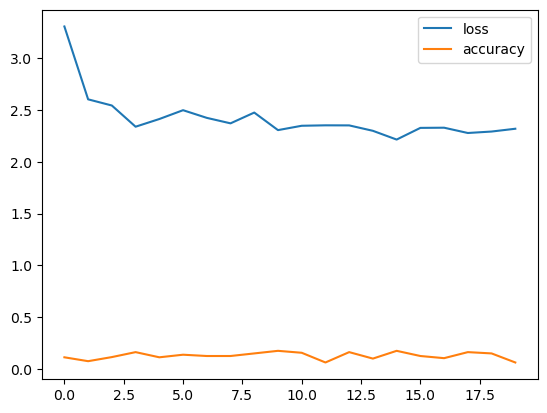

Found 40 images belonging to 8 classes.
2/2 [==============================] - 5s 1s/step - loss: 2.0970 - accuracy: 0.1250
Test Loss: 2.096970558166504
Test Accuracy: 0.125


In [ ]:
# plot loss and accuracy
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

# evaluate model
test_generator = load_image('test')

loss, accuracy = model.evaluate(test_generator)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")




In [ ]:
# save model
model.save('model.h5')


/Users/vickieduong/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
